### Methods of unsupervised ML clustering 

- Mean shift 
  -  the advantage of mean shift is that you dont need to know the number of clusters before hand, however it is computationally expensive 
- KMeans algorithm 

### Zero shot learning experimentation

tried with ["sustainable", "unsustainable"] \
tried with ["specifications", "comment"] \
tried with ["specifications", "random"] 

speeding up zero shot learning: 

https://towardsdatascience.com/parallel-inference-of-huggingface-transformers-on-cpus-4487c28abe23 \
https://towardsdatascience.com/hugging-face-transformer-inference-under-1-millisecond-latency-e1be0057a51c \

### Building of Unsupervised Clustering algorithm 

One hot encoding of categorical variables with many categories may lead to the curse of dimensionality problem 
- Use spectral encoding 
https://towardsdatascience.com/spectral-encoding-of-categorical-features-b4faebdf4a

In [4]:
import torch 
torch.cuda.is_available()

False

In [5]:
torch.cuda.current_device()
torch.cuda.get_device_name(0)

AssertionError: Torch not compiled with CUDA enabled

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import pandas as pd 
from nltk.corpus import stopwords 
from wordcloud import WordCloud, STOPWORDS
import math 
import statistics 
from sklearn.feature_extraction.text import CountVectorizer 
from textblob import TextBlob
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
import os 
import pandas as pd
from transformers import pipeline
import torch
import time
from datetime import timedelta
import psutil
import ray
import re


class SentimentAnalyser: 
    def __init__(self, dataframes): 
        df = dataframes
        df[2] = df.iloc[:][2].apply(lambda t: list(self.preprocess_text(i) for i in t)  )
        self.df = df
        self.combine_com = df[2].apply(self.combine_text)
        self.clean_data =pd.concat([df[[0,1]],self.combine_com],axis=1)
        self.dtm = self.get_topwords(self.combine_com)
        

        # for df in dataframes: 
        #     assert df.columns == ["model", "comments", "platform"]
        # df_combined = pd.concat(dataframes)
        # df_combined['cleaned_comments'] = df_combined['comments'].apply(lambda t: self.preprocess_text(t))
        # self.df_combined = df_combined
        # self.labels = {
        #     "zero_shot": "zero_shot", 
        #     "sentiment_analysis": "sentiment_analysis", 
        # }

    def preprocess_text(self, text):
        text = text.lower()                             # all lower case
        text = re.sub(r'\[.*?\]', ' ', text)            # remove text within [ ] (' ' instead of '')
        text = re.sub(r'\<.*?\>', ' ', text)            # remove text within < > (' ' instead of '')
        text = re.sub(r'http\S+', ' ', text)            # remove website ref http
        text = re.sub(r'www\S+', ' ', text)             # remove website ref www

        text = text.replace('€', 'euros')               # replace special character with words
        text = text.replace('£', 'gbp')                 # replace special character with words
        text = text.replace('$', 'dollar')              # replace special character with words
        text = text.replace('%', 'percent')             # replace special character with words
        text = text.replace('\n', ' ')                  # remove \n in text that has it

        text = text.replace('\'', '’')                  # standardise apostrophe
        text = text.replace('&#39;', '’')               # standardise apostrophe

        text = text.replace('’d', ' would')             # remove ’ (for would, should? could? had + PP?)
        text = text.replace('’s', ' is')                # remove ’ (for is, John's + N?)
        text = text.replace('’re', ' are')              # remove ’ (for are)
        text = text.replace('’ll', ' will')             # remove ’ (for will)
        text = text.replace('’ve', ' have')             # remove ’ (for have)
        text = text.replace('’m', ' am')                # remove ’ (for am)
        text = text.replace('can’t', 'can not')         # remove ’ (for can't)
        text = text.replace('won’t', 'will not')        # remove ’ (for won't)
        text = text.replace('n’t', ' not')              # remove ’ (for don't, doesn't)

        text = text.replace('’', ' ')                   # remove apostrophe (in general)
        text = text.replace('&quot;', ' ')              # remove quotation sign (in general)

        text = text.replace('cant', 'can not')          # typo 'can't' (note that cant is a proper word)
        text = text.replace('dont', 'do not')           # typo 'don't'

        text = re.sub(r'[^a-zA-Z0-9]', r' ', text)      # only alphanumeric left
        text = text.replace("   ", ' ')                 # remove triple empty space
        text = text.replace("  ", ' ')                  # remove double empty space

        tokens = TreebankWordTokenizer().tokenize(text)
        tokens = list(map(WordNetLemmatizer().lemmatize, tokens))
        preprocessed_text = " ".join(tokens)

        return preprocessed_text
        
    def Textblob(self): 
        df = self.df_combined.copy() 
        df[self.labels['sentiments_analysis']] = df['comments'].apply(lambda text: TextBlob(text).sentiment.polarity)
        return df 

    def BERTSentimentAnalysis(self): 
        df = self.df_combined.copy() 
        classifier = pipeline("sentiment-analysis") 
        df[self.labels['sentiments_analysis']] = df['comments'].apply(lambda text: classifier(text)[0]['label'])
        return df 
        
    def ZeroShot(self, candidates=["sustainable", "unsustainable"], use_gpu=False): 
        if use_gpu: 
            device_idx = 0
        else: 
            device_idx = -1
        df = self.df_combined.copy() 
        # classifier = pipeline("zero-shot-classification", device=0)
        classifier = pipeline("zero-shot-classification", model="valhalla/distilbart-mnli-12-3", device=device_idx)
        df[self.labels['zero_shot']] = df['comments'].apply(lambda text: classifier(text, candidate_labels=candidates)[0]['label']) 
        return df

    def combine_text(self,list_of_text):                     # define combine_text to take (list_of_text)
        combined_text = ' '.join(list_of_text)          # do this
        return combined_text  

    def get_topwords(self,data,dataframesgroupby_model=True): 

        extra_stopwords = ["wa", "doe", "ha", "video", "one", "subscribe", "channel", "watch", "watching", "thanks", "thank"] 
        all_stopwords = stopwords.words('english')
        all_stopwords.extend(extra_stopwords) 
        STOPWORDS.update(all_stopwords)

        '''create dtm'''
        cv = CountVectorizer(stop_words=all_stopwords)                       # initialise cv w/o stopwords
        data_cv = cv.fit_transform(data)                      # apply cv
        dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names(), index=pd.Series(self.df[0]))
        

        return dtm
    

# if __name__ == '__main__':
#     df = pd.read_pickle('combined_data.pkl')
#     sentiment_analysis(df)
#     df.to_csv('sentiment_analysis.csv')

[nltk_data] Downloading package stopwords to C:\Users\Pin
[nltk_data]     Nean\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Pin
[nltk_data]     Nean\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# load data into a df
data_folder = "support\coffee machine"
data_filename = "combined_data.pkl"
data_filepath = os.path.join(data_folder, data_filename)

df = pd.DataFrame(pd.read_pickle(data_filepath))
df.columns 

RangeIndex(start=0, stop=3, step=1)

In [5]:
# initialise an instance of SentimentAnalyser with cleaned text
df_test = SentimentAnalyser(df)
print(df_test.df)

                                                     0   1  \
0    Let’s Talk About The Breville Bambino Espresso...   1   
1    Let’s Talk About The Breville Bambino Espresso...   2   
2                 The Best Espresso Machine Under £500   1   
3                 The Best Espresso Machine Under £500   2   
4                 The Best Espresso Machine Under £500   3   
..                                                 ...  ..   
800  Why Cheap Coffee Makers Suck (And How To Fix T...  91   
801  Why Cheap Coffee Makers Suck (And How To Fix T...  92   
802  Why Cheap Coffee Makers Suck (And How To Fix T...  93   
803  Why Cheap Coffee Makers Suck (And How To Fix T...  94   
804  Why Cheap Coffee Makers Suck (And How To Fix T...  95   

                                                     2  
0    [very epic morgan i will watch this later but ...  
1    [nice review morgan i am going to order one ca...  
2    [how would you say the rancilio silvia compare...  
3    [i wish you linked to 

c:\Users\Pin Nean\Documents\SUTD\DAI_project\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [6]:
df_test.combine_com

0      very epic morgan i will watch this later but i...
1      nice review morgan i am going to order one can...
2      how would you say the rancilio silvia compare ...
3      i wish you linked to the basket you used i bou...
4      thank you so much your video very informative ...
                             ...                        
800    it wa hard to tell from the video but it looke...
801    james would you consider simply use the coffee...
802    if you are externally boiling the water then y...
803    having not watched this all the way through ye...
804    wait a second where is your outstanding sweate...
Name: 2, Length: 805, dtype: object

In [7]:
df_test.dtm

,00,000,000au,000gbp,001,007,00am,00pm,00s,01,...,zu,zura,zurich,zuriga,zutto,zweimal,zyada,zzzz,zzzzzzz,zzzzzzzzzzzzz
0,,,,,,,,,,,,,,,,,,,,,
Let’s Talk About The Breville Bambino Espresso Machine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Let’s Talk About The Breville Bambino Espresso Machine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The Best Espresso Machine Under £500,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The Best Espresso Machine Under £500,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The Best Espresso Machine Under £500,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Why Cheap Coffee Makers Suck (And How To Fix Them),0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Why Cheap Coffee Makers Suck (And How To Fix Them),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Why Cheap Coffee Makers Suck (And How To Fix Them),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df_test.clean_data

,0,1,2
0,Let’s Talk About The Breville Bambino Espresso...,1,very epic morgan i will watch this later but i...
1,Let’s Talk About The Breville Bambino Espresso...,2,nice review morgan i am going to order one can...
2,The Best Espresso Machine Under £500,1,how would you say the rancilio silvia compare ...
3,The Best Espresso Machine Under £500,2,i wish you linked to the basket you used i bou...
4,The Best Espresso Machine Under £500,3,thank you so much your video very informative ...
...,...,...,...
800,Why Cheap Coffee Makers Suck (And How To Fix T...,91,it wa hard to tell from the video but it looke...
801,Why Cheap Coffee Makers Suck (And How To Fix T...,92,james would you consider simply use the coffee...
802,Why Cheap Coffee Makers Suck (And How To Fix T...,93,if you are externally boiling the water then y...
803,Why Cheap Coffee Makers Suck (And How To Fix T...,94,having not watched this all the way through ye...


In [9]:
'''Exploratory Data Analysis'''
'''EDA - metadata'''
print("Summary of data...")
vid_index = []      # list of video index (from 1 to last video)
vid_words = []      # list of number of words in each video

for i in range(len(df_test.clean_data)):
    vid_index.append("Video_" + str(i+1))
    # print(df_test.clean_data.loc[i][2])
    vid_words.append(len(df_test.clean_data.loc[i][2].split()))

data_words = pd.DataFrame(list(zip(vid_index, vid_words)), columns=['Video Index', 'Total Words'])
print(data_words)


Summary of data...
    Video Index  Total Words
0       Video_1          444
1       Video_2          253
2       Video_3          578
3       Video_4          984
4       Video_5          663
..          ...          ...
800   Video_801         1149
801   Video_802         1706
802   Video_803          955
803   Video_804         1218
804   Video_805          387

[805 rows x 2 columns]


Plotting graph...


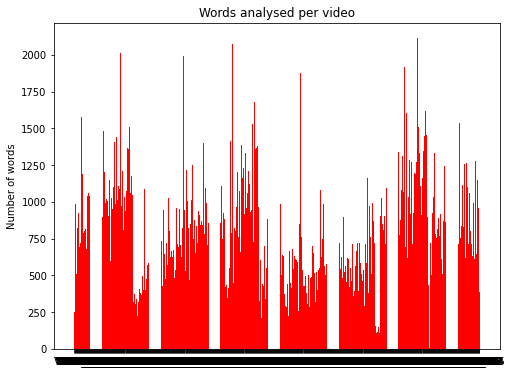

In [10]:
# Words analysed per video
import matplotlib.pyplot as plt

print("Plotting graph...")
fig = plt.figure(figsize=(8, 6))
plt.bar(vid_index, vid_words, color='r')
plt.title('Words analysed per video')
plt.ylabel('Number of words')
# plt.xlabel('Video Index')
# plt.xticks(rotation=70, fontsize=8)
plt.show()

Creating WordClouds...


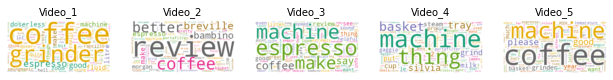

In [11]:
# sheak peak on the word cloud

'''EDA - WordCloud'''
print("Creating WordClouds...")
wc = WordCloud(stopwords=STOPWORDS, background_color="white", colormap="Dark2", collocations=False,
               max_font_size=150, include_numbers=True, random_state=42)  # add "max_words=10" to limit number of words
fig2 = plt.figure(figsize=(64, 40))

for i in range(5):
    if len(df_test.clean_data.loc[i][2]) != 0:     # WordCloud needs at least one word
        wc.generate(df_test.clean_data.loc[i][2])  # a WordCloud for each video
    else:
        wc.generate("empty")

    r = math.floor(math.sqrt(len(df_test.clean_data)))
    c = math.ceil(len(df_test.clean_data)/r)
    plt.subplot(r, c, i + 1)        # plt.subplot(rows, cols, index), remove to plot individual video

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(vid_index[i], fontsize=10)

plt.show()

Creating WordClouds...


Text(0.5, 1.0, 'all words')

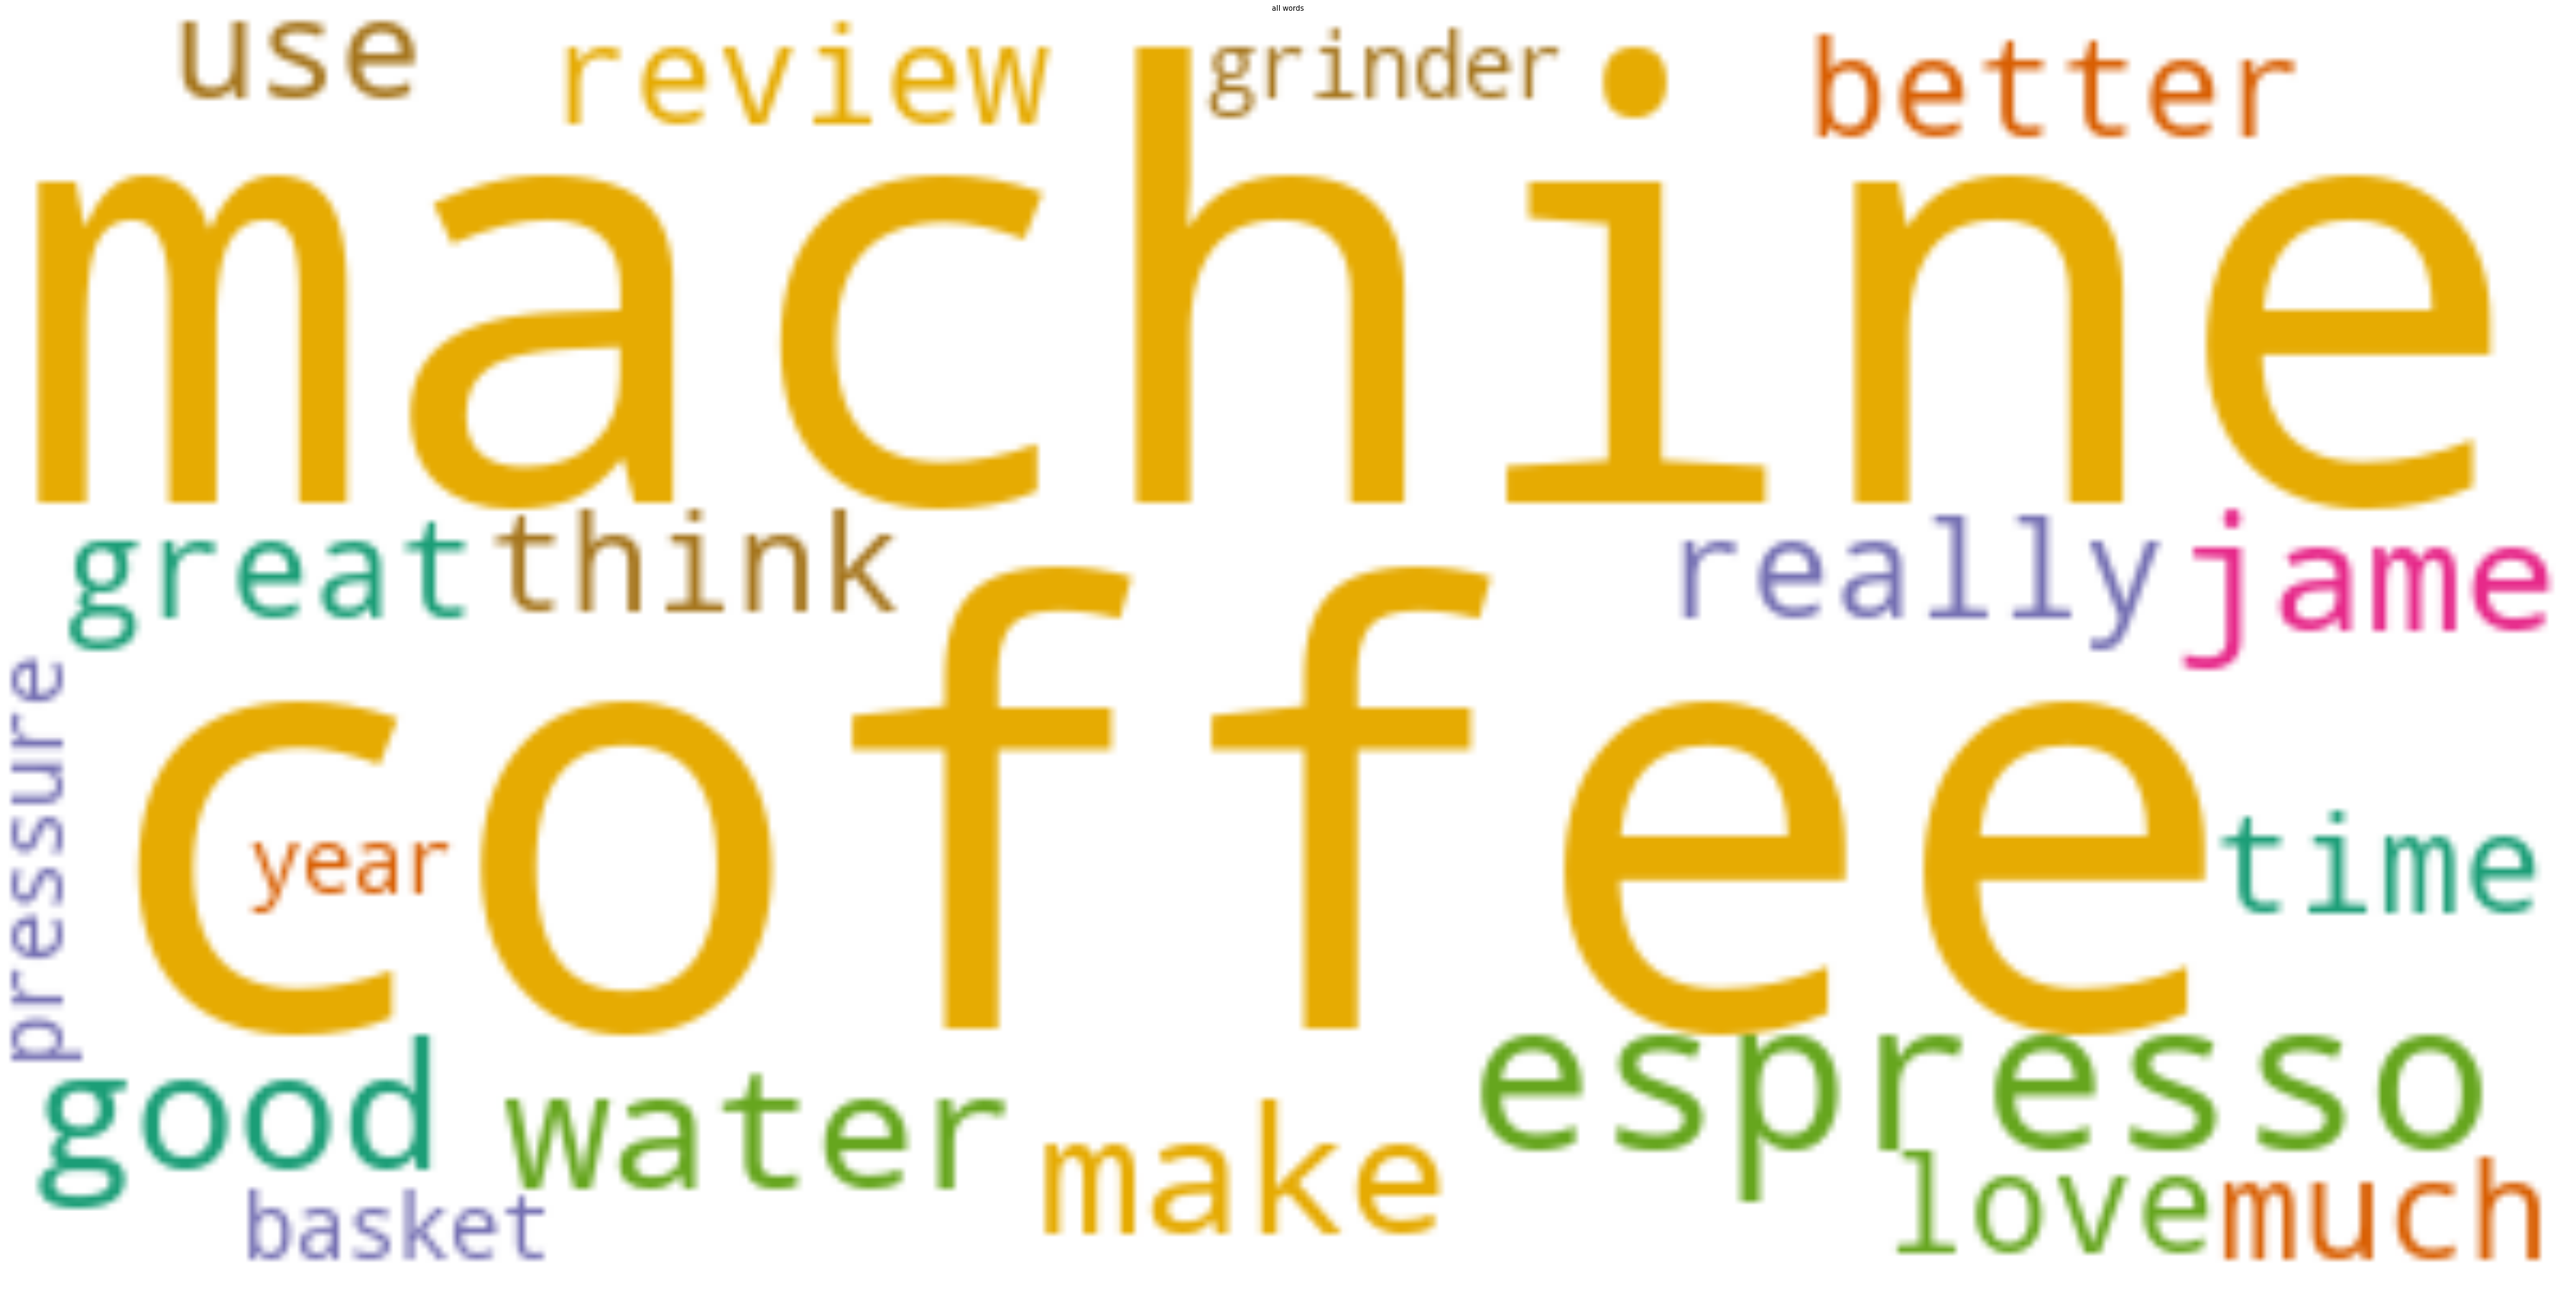

In [13]:
# top count without stopwords
'''EDA - WordCloud'''
print("Creating WordClouds...")
wc = WordCloud(stopwords=STOPWORDS, background_color="white", colormap="Dark2", collocations=False,
               max_font_size=150, include_numbers=True, random_state=42,max_words=20)  # add "max_words=10" to limit number of words
fig3 = plt.figure(figsize=(64, 40))
l = []

for i in range(len(df_test.clean_data)):
    l.append(df_test.clean_data.loc[i][2])
all_words = ''.join(l)
wc.generate(all_words)
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.title("all words", fontsize=10)


In [16]:
#find top word counts with stopwords

from collections import Counter
from nltk.util import everygrams
from gensim.parsing.preprocessing import remove_stopwords , STOPWORDS



extra_stopwords = ["i","wa", "doe", "ha", "video", "one", "subscribe", "channel", "watch", "watching", "thanks", "thank", "like",'good','hell','think','coffee','machine'] 
all_stopwords = stopwords.words('english')
all_stopwords.extend(extra_stopwords) 
'''user inputs'''
e_grams_max = 5         # Maximum length of every-grams (i.e. 1 = single word)
e_grams_cut = 30    

'''EDA - top word'''
print("Finding top words...")
top_words = []      # list of top words by video
top = []            # list of top words in each video

for i in range(len(df_test.clean_data)):
    text = " ".join(word for word in df_test.clean_data.loc[i][2].split() if word not in all_stopwords)
    text = remove_stopwords(text)
    e_grams_counts = Counter(everygrams(text.split(), max_len=e_grams_max))
    e_grams_most = e_grams_counts.most_common(e_grams_cut)
    print("Video ", str(i+1))
    print(e_grams_most)
    # Copy & Paste

    for j in range(len(e_grams_most)):
        top.append([" ".join(e_grams_most[j][0]), e_grams_most[j][1]])
    top_words.append(top.copy())
    top.clear()

Finding top words...
Video  1
[(('grinder',), 6), (('espresso',), 6), (('doserless',), 3), (('fluid',), 3), (('litre',), 3), (('zoom',), 2), (('swingmanic',), 2), (('bit',), 2), (('doser',), 2), (('grinder', 'doserless'), 2), (('rancilio',), 2), (('rancilio', 'rocky'), 2), (('rancilio', 'rocky', 'grinder'), 2), (('rocky',), 2), (('rocky', 'grinder'), 2), (('lol',), 2), (('portafilter',), 2), (('crema',), 2), (('drink',), 2), (('drink', 'espresso'), 2), (('time',), 2), (('fluid', 'litre'), 2), (('thing',), 2), (('epic',), 1), (('epic', 'morgan'), 1), (('epic', 'morgan', 'later'), 1), (('epic', 'morgan', 'later', 'im'), 1), (('epic', 'morgan', 'later', 'im', 'zoom'), 1), (('morgan',), 1), (('morgan', 'later'), 1)]
Video  2
[(('review',), 4), (('better',), 3), (('breville',), 3), (('bambino',), 3), (('espresso',), 3), (('morgan',), 2), (('portafilter',), 2), (('basket',), 2), (('cup',), 2), (('breville', 'bambino'), 2), (('pretty',), 2), (('1',), 2), (('nice',), 1), (('nice', 'review'), 1

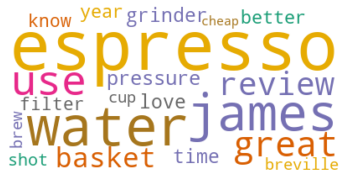

{'grinder': 972,
 'espresso': 3688,
 'bit': 230,
 'rancilio': 231,
 'portafilter': 298,
 'drink': 228,
 'time': 945,
 'thing': 570,
 'review': 1041,
 'better': 893,
 'breville': 696,
 'bambino': 204,
 'basket': 1000,
 'cup': 659,
 'want': 574,
 'great': 1097,
 'love': 945,
 'point': 222,
 'gaggia': 599,
 'maker': 536,
 'hot': 393,
 'dedica': 262,
 'silvia': 439,
 'grind': 333,
 'milk': 436,
 'steam': 440,
 '2': 214,
 'pro': 352,
 'pid': 344,
 'james': 1843,
 'bought': 354,
 'year': 877,
 'water': 2161,
 'classic': 260,
 'sage': 648,
 'drip': 257,
 'temperature': 270,
 'lelit': 269,
 'know': 746,
 'work': 388,
 'pressure': 997,
 'delonghi': 618,
 'shot': 706,
 'got': 633,
 'price': 638,
 'quality': 248,
 'way': 385,
 'bar': 320,
 'maybe': 228,
 'boiler': 501,
 'home': 237,
 'buy': 462,
 'use': 1200,
 'need': 384,
 'best': 500,
 'barista': 274,
 'u': 226,
 'guy': 234,
 'new': 232,
 'day': 223,
 'pour': 294,
 'decent': 211,
 'aldi': 576,
 'people': 413,
 'look': 423,
 'brew': 693,
 'cheap

In [54]:

import multidict 
word_dict = {}
fullTermsDict = multidict.MultiDict()

for video in top_words:
    for word in video:
        if word[0] not in word_dict:
            word_dict[word[0]] = word[1] 
        else:
            word_dict[word[0]] += word[1]
# word_dict

for key in word_dict:
    fullTermsDict.add(key, word_dict[key])

# fullTermsDict

wc.generate_from_frequencies(fullTermsDict)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

new_word_dict = {}
for k,v in word_dict.items():
    if word_dict[k] > 200:
        new_word_dict[k] = word_dict[k]
new_word_dict


In [55]:
top10_words = []

for i in range(10):
    fin_max = max(word_dict, key=word_dict.get)
    top10_words.append(fin_max)
    del word_dict[fin_max]
    print("Maximum value:",fin_max)

print(top10_words)

Maximum value: espresso
Maximum value: water
Maximum value: james
Maximum value: use
Maximum value: great
Maximum value: review
Maximum value: basket
Maximum value: pressure
Maximum value: grinder
Maximum value: time
['espresso', 'water', 'james', 'use', 'great', 'review', 'basket', 'pressure', 'grinder', 'time']


In [64]:
ner_word = ' '.join(new_word_dict.keys())

print(ner_word)

import spacy
# python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')
  
doc = nlp(ner_word)
top_propn = []
top_noun = []
top_adj = []
top_aux = []
top_verb = []
top_num = []
top_adp = []
top_sym = []
for tok in doc:
    print(tok, tok.pos_)
    if tok.pos_ == 'PROPN':
        top_propn.append(tok.text)
    elif tok.pos_ == 'NOUN':
        top_noun.append(tok.text)
    elif tok.pos_ == 'ADJ':
        top_adj.append(tok.text)
    elif tok.pos_ == 'AUX':
        top_aux.append(tok.text)
    elif tok.pos_ == 'VERB':
        top_verb.append(tok.text)
    elif tok.pos_ == 'NUM':
        top_num.append(tok.text)
    elif tok.pos_ == 'ADP':
        top_adp.append(tok.text)
    else:
        top_sym.append(tok.text)





# for ent in doc.ents:
#     print(ent.text, ent.pos_, ent.label_)


grinder espresso bit rancilio portafilter drink time thing review better breville bambino basket cup want great love point gaggia maker hot dedica silvia grind milk steam 2 pro pid james bought year water classic sage drip temperature lelit know work pressure delonghi shot got price quality way bar maybe boiler home buy use need best barista u guy new day pour decent aldi people look brew cheap bean money filter dual ground dual boiler moccamaster carafe brewer
grinder PROPN
espresso NOUN
bit PROPN
rancilio NOUN
portafilter NOUN
drink NOUN
time NOUN
thing NOUN
review AUX
better ADJ
breville PROPN
bambino PROPN
basket PROPN
cup PROPN
want VERB
great ADJ
love NOUN
point NOUN
gaggia PROPN
maker PROPN
hot PROPN
dedica PROPN
silvia PROPN
grind PROPN
milk NOUN
steam NOUN
2 NUM
pro ADJ
pid NOUN
james NOUN
bought VERB
year NOUN
water NOUN
classic ADJ
sage NOUN
drip VERB
temperature NOUN
lelit NOUN
know VERB
work NOUN
pressure NOUN
delonghi NOUN
shot NOUN
got VERB
price NOUN
quality NOUN
way NO

In [69]:
top_noun

['espresso',
 'rancilio',
 'portafilter',
 'drink',
 'time',
 'thing',
 'love',
 'point',
 'milk',
 'steam',
 'pid',
 'james',
 'year',
 'water',
 'sage',
 'temperature',
 'lelit',
 'work',
 'pressure',
 'delonghi',
 'shot',
 'price',
 'quality',
 'way',
 'bar',
 'boiler',
 'home',
 'buy',
 'use',
 'day',
 'people',
 'bean',
 'money',
 'filter',
 'ground',
 'boiler',
 'moccamaster']

In [59]:
from spacy import displacy

displacy.render(doc, style='dep', jupyter=True, options={'distance': 110})

In [29]:
clean_comments = df_test.df[2]
clean_comments

0      [very epic morgan i will watch this later but ...
1      [nice review morgan i am going to order one ca...
2      [how would you say the rancilio silvia compare...
3      [i wish you linked to the basket you used i bo...
4      [thank you so much your video very informative...
                             ...                        
800    [it wa hard to tell from the video but it look...
801    [james would you consider simply use the coffe...
802    [if you are externally boiling the water then ...
803    [having not watched this all the way through y...
804    [wait a second where is your outstanding sweat...
Name: 2, Length: 805, dtype: object

In [37]:
top_plot

[[[], []],
 [[], []],
 [[], []],
 [[1], [0.0]],
 [[1], [-0.12222222222222223]],
 [[], []],
 [[], []],
 [[], []],
 [[1], [-0.2]],
 [[], []],
 [[1], [0.24791666666666667]],
 [[1, 2, 3], [0.55, 0.5, 0.33666666666666667]],
 [[1], [0.33666666666666667]],
 [[1], [0.55]],
 [[1], [0.0]],
 [[1], [0.25]],
 [[1, 2, 3], [0.5, 0.33666666666666667, 0.25]],
 [[], []],
 [[1, 2], [0.0, 0.3]],
 [[], []],
 [[1, 2], [0.35166666666666674, 0.030000000000000027]],
 [[], []],
 [[], []],
 [[], []],
 [[], []],
 [[], []],
 [[], []],
 [[1], [0.25]],
 [[1], [0.030000000000000027]],
 [[1], [0.09249999999999999]],
 [[], []],
 [[1], [0.38333333333333336]],
 [[1, 2, 3], [0.4333333333333333, 0.09183673469387754, 0.06770833333333333]],
 [[1], [0.38333333333333336]],
 [[], []],
 [[1], [0.2815789473684211]],
 [[1], [0.40606060606060607]],
 [[], []],
 [[1, 2], [-0.0035714285714285865, 0.04417989417989418]],
 [[], []],
 [[1], [0.5]],
 [[], []],
 [[1, 2, 3, 4], [0.12333333333333334, -0.033333333333333326, 0.1, 0.25]],
 [[], 

In [9]:
from transformers import pipeline

candidates = ["sustainable", "unsustainable"]
# classifier = pipeline("zero-shot-classification", device=0)
classifier = pipeline("zero-shot-classification", model="valhalla/distilbart-mnli-12-3", device=-1)

In [16]:
comments = df[2]
print(comments)

0      [very epic morgan. i will watch this later but...
1      [Nice review Morgan! I&#39;m going to order on...
2      [How would you say the Rancilio Silvia compare...
3      [I wish you linked to the baskets you used. <b...
4      [Thank you so much,  your videos very informat...
                             ...                        
800    [It was hard to tell from the video, but it lo...
801    [James, would you consider simply use the coff...
802    [If you&#39;re externally boiling the water, t...
803    [Having not watched this all the way through y...
804    [Wait a second, where&#39;s your &quot;Outstan...
Name: 2, Length: 805, dtype: object


In [14]:
%%time
classifier(comments[0]+comments[1]+comments[2], candidate_labels=['coffee machine', 'youtube video','dispense','others']) #use more suggestive labels for youtube context

CPU times: total: 6min 22s
Wall time: 48 s


[{'sequence': 'very epic morgan. i will watch this later but im in zoom :)',
  'labels': ['others', 'dispense', 'youtube video', 'coffee machine'],
  'scores': [0.6849469542503357,
   0.1719023436307907,
   0.11813350766897202,
   0.02501720003783703]},
 {'sequence': 'I watched this in zoom too, what a coincidence',
  'labels': ['others', 'youtube video', 'dispense', 'coffee machine'],
  'scores': [0.7173128128051758,
   0.14053137600421906,
   0.12233678996562958,
   0.019819015637040138]},
 {'sequence': '@swingmanic That would be quite a bit of retention, though: I&#39;d say if you don&#39;t like the doser, get rid of it.',
  'labels': ['dispense', 'others', 'coffee machine', 'youtube video'],
  'scores': [0.8023352026939392,
   0.18047229945659637,
   0.00967434048652649,
   0.00751816900447011]},
 {'sequence': '@Nick Lai I guess it could be done but I&#39;ve learnt to live with it.',
  'labels': ['others', 'dispense', 'youtube video', 'coffee machine'],
  'scores': [0.6284742951393

In [52]:
%%time 

df[3] = df[2].apply(lambda text: classifier(text, candidate_labels=candidates)['labels'][0])

Wall time: 13min 9s


In [54]:
df[3][0]

[{'sequence': 'very epic morgan. i will watch this later but im in zoom :)',
  'labels': ['sustainable', 'unsustainable'],
  'scores': [0.6536259055137634, 0.34637412428855896]},
 {'sequence': 'I watched this in zoom too, what a coincidence',
  'labels': ['sustainable', 'unsustainable'],
  'scores': [0.5213230848312378, 0.4786769151687622]},
 {'sequence': '@swingmanic That would be quite a bit of retention, though: I&#39;d say if you don&#39;t like the doser, get rid of it.',
  'labels': ['sustainable', 'unsustainable'],
  'scores': [0.5466828346252441, 0.45331722497940063]},
 {'sequence': '@Nick Lai I guess it could be done but I&#39;ve learnt to live with it.',
  'labels': ['sustainable', 'unsustainable'],
  'scores': [0.6443400979042053, 0.3556598722934723]},
 {'sequence': '@swingmanic Can&#39;t you mod the grinder to become doserless?',
  'labels': ['unsustainable', 'sustainable'],
  'scores': [0.6100789308547974, 0.389921098947525]},
 {'sequence': '@DJ NC It&#39;s a Rancilio Rocky

C:\Users\Clarence\Documents\School\1. DAI\AI_code\ai_env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


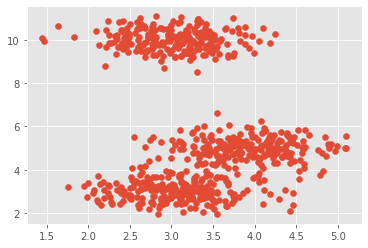

In [74]:
%matplotlib inline
import numpy as np
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from sklearn.datasets.samples_generator import make_blobs
centers = [[3,3,3],[4,5,5],[3,10,10]]
X, _ = make_blobs(n_samples = 700, centers = centers, cluster_std = 0.5)
plt.scatter(X[:,0],X[:,1])
plt.show()

[[ 2.92734352  2.95552978  3.031273  ]
 [ 3.99308599  5.00144907  5.02786531]
 [ 2.96613058 10.03029845 10.02589725]]
Estimated clusters: 3


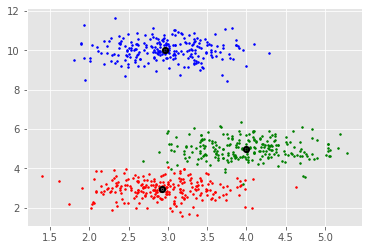

In [29]:
ms = MeanShift()
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
print(cluster_centers)
n_clusters_ = len(np.unique(labels))
print("Estimated clusters:", n_clusters_)
colors = 10*['r.','g.','b.','c.','k.','y.','m.']
for i in range(len(X)):
    plt.plot(X[i][0], X[i][1], colors[labels[i]], markersize = 3)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],
    marker=".",color='k', s=20, linewidths = 5, zorder=10)
plt.show()

### Trying out Meanshift algorithm with TV data

In [62]:
df_uncleaned = pd.read_csv('data/TV.csv')
df_uncleaned.head()

,Title,Price,Sold,Reviews,Condition,Display Technology,Model,Maximum Resolution,Refresh Rate,Features,...,Tuner digital integrated3,Tuner digital integrated4,Functionality Smart TV1,Inputs Audio / Video1,Tuner digital integrated,Functionality Smart TV2,Size,Televisions:Screen_Size_Class,Home_Video:Series,Bundle Description
0,"Insignia 24"" HD 720p Class F20 Series LED Smar...",108.98,143 sold,,"New: A brand-new, unused, unopened, undamaged ...",LED,NS-24DF310NA21,HD (720p),60Hz,Works with Amazon Alexa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"TCL 32"" Class HD LED Android Smart TV 3-Series...",159.99,28 sold,,"New: A brand-new, unused, unopened, undamaged ...",LED,3-Series,720p (HD),NaN,"Dolby Audio, HD Picture Quality, Hey Google / ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"NEW ROKU Smart TV 40"" FHD LED H4030F Series 40...",,,,"New: A brand-new, unused, unopened, undamaged ...",LED,Hisense 43H5500G,1080p (FHD),NaN,Wall Mountable,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Samsung - 43"" Class 7 Series LED 4K UHD Smart ...",275.0,6 watchers,"['I cannot connect to computer, and cannot rep...","New: A brand-new, unused, unopened, undamaged ...",LED,Samsung TU7000,2160p (4K),NaN,"Wi-Fi Enabled, Wall Mountable",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Onn 75"" Class 4k UHD (2160p) LED Frameless Rok...",599.0,,,"New: A brand-new, unused, unopened, undamaged ...",LED,100044717,2160p (4K),60 Hz,Thin Bezel,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
df_uncleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 74 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Title                                     72 non-null     object 
 1   Price                                     71 non-null     object 
 2   Sold                                      72 non-null     object 
 3   Reviews                                   72 non-null     object 
 4   Condition                                 72 non-null     object 
 5   Display Technology                        72 non-null     object 
 6   Model                                     72 non-null     object 
 7   Maximum Resolution                        72 non-null     object 
 8   Refresh Rate                              45 non-null     object 
 9   Features                                  52 non-null     object 
 10  Color                                   

In [133]:
df = df_uncleaned.copy()
df.dropna(axis=1, how='any', thresh=0.9*df.shape[0], inplace=True)
df = df[df.columns[df.nunique() > 1]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Title               72 non-null     object
 1   Price               71 non-null     object
 2   Sold                72 non-null     object
 3   Reviews             72 non-null     object
 4   Display Technology  72 non-null     object
 5   Model               72 non-null     object
 6   Maximum Resolution  72 non-null     object
 7   Brand               72 non-null     object
 8   Screen Size         71 non-null     object
dtypes: object(9)
memory usage: 5.2+ KB


In [169]:
cols_to_drop = ["Title", "Reviews", "Brand", "Sold", "Model"]
df.drop(cols_to_drop, axis=1, inplace=True)

KeyError: "['Title' 'Reviews' 'Brand' 'Sold' 'Model'] not found in axis"

In [135]:
# df["Energy Star"] = df_uncleaned["Energy Star"]

In [136]:
df_uncleaned["Energy Star"].unique()

array([nan, 'A', 'Not Compliant', '5 Stars', 'Compliant', '1 Star',
       'A+++', '2 Stars', 'A+', 'see pack'], dtype=object)

In [137]:
# df["Price"] = df["Price"].apply(lambda text: str(text).strip())

In [138]:
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

In [144]:
pd.to_numeric(df['Screen Size'].str.extract('(\d+)')[0])

0     24.0
1     32.0
2     40.0
3     43.0
4     75.0
      ... 
67    32.0
68    32.0
69    43.0
70    50.0
71    32.0
Name: 0, Length: 72, dtype: float64

In [145]:
df["Screen Size"] = pd.to_numeric(df['Screen Size'].str.extract('(\d+)')[0], errors="coerce")

In [146]:
df.dropna(inplace=True)

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 0 to 71
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price               59 non-null     float64
 1   Display Technology  59 non-null     object 
 2   Maximum Resolution  59 non-null     object 
 3   Screen Size         59 non-null     float64
dtypes: float64(2), object(2)
memory usage: 2.3+ KB


In [148]:
df[["Price", "Screen Size"]] = df[["Price", "Screen Size"]].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

In [149]:
df.shape

(59, 4)

In [150]:
df

,Price,Display Technology,Maximum Resolution,Screen Size
0,-1.070711,LED,HD (720p),-1.548422
1,-0.956505,LED,720p (HD),-1.069173
3,-0.699012,LED,2160p (4K),-0.410205
4,0.026383,LED,2160p (4K),1.506792
5,0.742823,LED,2160p (4K),0.308669
6,-0.643041,LED,2160p (4K),1.506792
7,2.939137,LED,4320p (8K),1.446886
13,0.577146,QLED,2160p (4K),1.506792
14,-0.493058,LED,2160p (4K),0.009138
15,-0.934117,LED,1080p,-1.069173


In [151]:
df = pd.get_dummies(df, columns = ["Display Technology", "Maximum Resolution"])

In [165]:
df.columns

Index(['Price', 'Screen Size', 'Display Technology_Full-Array LED-LCD',
       'Display Technology_HD', 'Display Technology_LCD',
       'Display Technology_LED', 'Display Technology_OLED',
       'Display Technology_QLED', 'Display Technology_SMART 4K TV',
       'Maximum Resolution_1080p', 'Maximum Resolution_1080p (FHD)',
       'Maximum Resolution_2160p (4K)',
       'Maximum Resolution_2160p 4K UHD 3840x2160',
       'Maximum Resolution_3840 x 2160 Pixel',
       'Maximum Resolution_3840x2160 (4K UHD)',
       'Maximum Resolution_4320p (8K)', 'Maximum Resolution_4K',
       'Maximum Resolution_4K UHD', 'Maximum Resolution_720P',
       'Maximum Resolution_720p', 'Maximum Resolution_720p (HD)',
       'Maximum Resolution_768p', 'Maximum Resolution_Full HD LED Smart TV',
       'Maximum Resolution_HD (720p)', 'Maximum Resolution_SMART 4K TV',
       'Maximum Resolution_SMART LED TV 32"',
       'Maximum Resolution_‎1920 x 1080 pixels'],
      dtype='object')

[[-0.27450281 -0.13217886  0.          0.          0.          0.87179487
   0.02564103  0.1025641   0.          0.02564103  0.05128205  0.66666667
   0.02564103  0.02564103  0.          0.          0.          0.02564103
   0.          0.02564103  0.07692308  0.02564103  0.02564103  0.
   0.          0.02564103  0.        ]
 [ 2.33913541  1.34205021  0.          0.          0.          0.75
   0.25        0.          0.          0.          0.          0.75
   0.          0.          0.          0.25        0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 2.93913713  3.36388298  0.          0.          0.          1.
   0.          0.          0.          1.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.92414957 -0.41020487  0.          0.          0.          

IndexError: index 59 is out of bounds for axis 0 with size 59

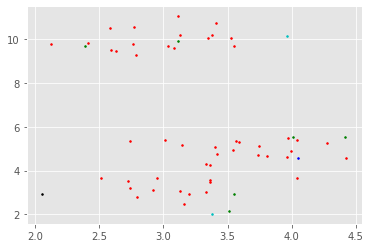

In [152]:
ms = MeanShift()
ms.fit(df)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
print(cluster_centers)
n_clusters_ = len(np.unique(labels))
print("Estimated clusters:", n_clusters_)
colors = 10*['r.','g.','b.','c.','k.','y.','m.']
for i in range(len(X)):
    plt.plot(X[i][0], X[i][1], colors[labels[i]], markersize = 3)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],
    marker=".",color='k', s=20, linewidths = 5, zorder=10)
plt.show()

In [155]:
good_ratings = ["A", "5 Stars", "A+", "A+++"]

df[df_uncleaned["Energy Star"].isin(good_ratings)]

C:\Users\Clarence\AppData\Local\Temp/ipykernel_36024/2093813761.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df_uncleaned["Energy Star"].isin(good_ratings)]


,Price,Screen Size,Display Technology_Full-Array LED-LCD,Display Technology_HD,Display Technology_LCD,Display Technology_LED,Display Technology_OLED,Display Technology_QLED,Display Technology_SMART 4K TV,Maximum Resolution_1080p,...,Maximum Resolution_4K UHD,Maximum Resolution_720P,Maximum Resolution_720p,Maximum Resolution_720p (HD),Maximum Resolution_768p,Maximum Resolution_Full HD LED Smart TV,Maximum Resolution_HD (720p),Maximum Resolution_SMART 4K TV,"Maximum Resolution_SMART LED TV 32""",Maximum Resolution_‎1920 x 1080 pixels
1,-0.956505,-1.069173,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
13,0.577146,1.506792,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
25,-0.777373,-0.410205,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29,-0.922922,-1.069173,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
60,-0.419153,0.009138,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,-0.665452,-1.548422,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
63,-0.441564,-0.649829,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
66,-0.419175,-0.649829,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
68,0.474158,-1.069173,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [166]:
import math

def closest_clusters(row, cluster_centers): 
    max_idx = 0
    min_dist = float("inf")
    for i, cluster in enumerate(cluster_centers): 
        dist = math.sqrt(sum(map(lambda x: x**2, row - cluster)))
        if dist < min_dist: 
            min_dist = dist 
            idx = i
    return idx

df_classified = df.apply(lambda row: closest_clusters(row, cluster_centers), axis=1) 
        

In [168]:
df_classified

0     0
1     0
3     0
4     0
5     0
6     0
7     1
13    1
14    0
15    0
16    0
17    0
18    0
20    0
21    0
22    0
23    1
24    0
25    0
26    0
27    0
29    0
30    0
32    0
33    0
34    0
35    3
36    0
37    3
38    1
39    0
40    0
41    1
42    0
43    0
44    0
45    0
46    0
48    0
49    0
50    0
51    2
52    4
53    0
54    0
55    0
56    0
57    0
60    0
61    0
62    0
63    0
64    1
65    0
66    0
67    0
68    0
70    0
71    0
dtype: int64

In [167]:
df_classified[df_uncleaned["Energy Star"].isin(good_ratings)]

1     0
13    1
25    0
29    0
60    0
61    0
63    0
66    0
68    0
dtype: int64

In [156]:
cluster_centers

array([[-0.27450281, -0.13217886,  0.        ,  0.        ,  0.        ,
         0.87179487,  0.02564103,  0.1025641 ,  0.        ,  0.02564103,
         0.05128205,  0.66666667,  0.02564103,  0.02564103,  0.        ,
         0.        ,  0.        ,  0.02564103,  0.        ,  0.02564103,
         0.07692308,  0.02564103,  0.02564103,  0.        ,  0.        ,
         0.02564103,  0.        ],
       [ 2.33913541,  1.34205021,  0.        ,  0.        ,  0.        ,
         0.75      ,  0.25      ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.75      ,  0.        ,  0.        ,  0.        ,
         0.25      ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 2.93913713,  3.36388298,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.    

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 32 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Price                                      72 non-null     float64
 1   Screen Size                                72 non-null     object 
 2   Display Technology_Does not apply          72 non-null     uint8  
 3   Display Technology_Full-Array LED-LCD      72 non-null     uint8  
 4   Display Technology_HD                      72 non-null     uint8  
 5   Display Technology_HDR                     72 non-null     uint8  
 6   Display Technology_LCD                     72 non-null     uint8  
 7   Display Technology_LED                     72 non-null     uint8  
 8   Display Technology_ND                      72 non-null     uint8  
 9   Display Technology_OLED                    72 non-null     uint8  
 10  Display Technology_QLED     